# Load forecasting for MDEV and HDEV

## Basic approach

For each year: <br> 

    No. of MDEVs * Avg No. of KMs * Avg Mileage = Total Power requirement 
<br>
    Same applies for HDEV <br>
    
## Forecasting number of MDEV
<ol>
    <li>Historical Data</li>
    <li> Business license renewals (“BLR”) </li>
    <li> gross domestic product (“GDP”) proved to be good indicators of vehicle</li> 
 
</ol>

## Forecasting market share of EVs among them
<ol>
    <li> Adoption rate (Federal + Provincial) </li>
</ol>

Dunsky use GDP. Dunsky use different classes of MDEV and do forecast for all of them. <br>
Enerstrat Canada use GDP and Business license renewals.
 
    



## Data formatting

In [353]:
# formatting vehicle registration data
import pandas as pd 
import matplotlib.pyplot as plt

import glob
filenames = glob.glob('../data/raw_data/vehicle_registration/*.csv') 
vehicle_registration_full = pd.DataFrame()
for f in filenames:
    registration_data = pd.read_csv(f)
    cols_to_drop = ['DGUID', 'Statistics', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE','STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']
    cols_to_rename = {'REF_DATE':'year', 'GEO': 'province', 'Vehicle Type': 'vehicle_type', 'Fuel Type': 'fuel_type', "VALUE": 'value'}
    registration_data = registration_data.drop(columns=cols_to_drop)
    registration_data = registration_data.rename(columns=cols_to_rename)
    vehicle_registration_full =pd.concat([vehicle_registration_full, registration_data], ignore_index=True)

vehicle_registration_full.fillna(0)
#vehicle_registration_full.to_csv('provicewise_vehicle_registration_data.csv')

,year,province,vehicle_type,fuel_type,value
0,2017,Alberta,"Total, road motor vehicle registrations",All fuel types,3472713.0
1,2018,Alberta,"Total, road motor vehicle registrations",All fuel types,3522981.0
2,2019,Alberta,"Total, road motor vehicle registrations",All fuel types,3577116.0
3,2020,Alberta,"Total, road motor vehicle registrations",All fuel types,3543331.0
4,2021,Alberta,"Total, road motor vehicle registrations",All fuel types,3548915.0
...,...,...,...,...,...
7002,2019,Yukon,Motorcycles and mopeds,Other fuel types,0.0
7003,2020,Yukon,Motorcycles and mopeds,Other fuel types,0.0
7004,2021,Yukon,Motorcycles and mopeds,Other fuel types,0.0
7005,2022,Yukon,Motorcycles and mopeds,Other fuel types,0.0


## Read GDP data

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

gdp_filename = '../data/formatted_data/gdp_data.xls'
gdp_data = pd.read_excel(gdp_filename)

cols = [i for i in range(1980, 2030)]
gdp_arr = gdp_data[cols]
gdp_arr_long = pd.melt(gdp_arr, value_vars=cols, var_name='year')


# Forecasting GDP data

,year,value
0,1980,2.2
1,1981,3.5
2,1982,-3.2
3,1983,2.6
4,1984,5.9
5,1985,4.7
6,1986,2.1
7,1987,4.1
8,1988,4.4
9,1989,2.3


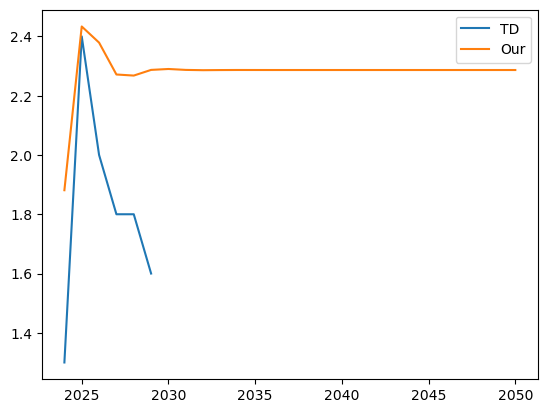

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg


# forecasting GDP

#load data
gdp_filename = '../data/formatted_data/gdp_data.xls'
gdp_data = pd.read_excel(gdp_filename)

cols = [i for i in range(1980, 2030)] #gdp data availability
gdp_arr = gdp_data[cols]
gdp_arr_long = pd.melt(gdp_arr, value_vars=cols, var_name='year')
gdp_arr_long.set_index('year')

# build model
start_year_gdp = 2024
end_year_gdp = 2050
cut_off_year = 2030-start_year_gdp
model = ARIMA(gdp_arr_long['value'][0:-cut_off_year], order=(2,0,1))
fitted_model = model.fit()

# Forecast future points
forecast_years = [i for i in range(start_year_gdp, end_year_gdp+1)]
forecast_steps = len(forecast_years)

gdp_forecast_data = fitted_model.get_forecast(steps=forecast_steps).predicted_mean



result_df = pd.DataFrame()

plt.plot( gdp_arr_long['year'][-cut_off:], gdp_arr_long['value'][-cut_off:], label='TD')
plt.plot(forecast_years, gdp_forecast_data, label='Our')
plt.legend()

gdp_arr_long

## Predict the number of M/HDV based on GDP forecast

In [173]:
#read data for past increase in M/HDV
import re 
vehicle_registration_data = pd.read_csv('../data/formatted_data/provincewise_vehicle_registration_data_formatted.csv')
mdv = "Total, vehicles weighing 4,536 to 11,793 kilograms" 
hdv = 'Total, vehicles weighing 11,794 kilograms or more'
mdv=hdv

province='Alberta'
mdv_data = vehicle_registration_data[(vehicle_registration_data['vehicle_type']==mdv) \
                                              & (vehicle_registration_data['fuel_type']=='All fuel types') \
                                                & (vehicle_registration_data['province']==province)]
mdv_data

,Unnamed: 0,year,province,vehicle_type,fuel_type,value
392,392,2017,Alberta,"Total, vehicles weighing 11,794 kilograms or more",All fuel types,119138.0
393,393,2018,Alberta,"Total, vehicles weighing 11,794 kilograms or more",All fuel types,122461.0
394,394,2019,Alberta,"Total, vehicles weighing 11,794 kilograms or more",All fuel types,123504.0
395,395,2020,Alberta,"Total, vehicles weighing 11,794 kilograms or more",All fuel types,117892.0
396,396,2021,Alberta,"Total, vehicles weighing 11,794 kilograms or more",All fuel types,120217.0
397,397,2022,Alberta,"Total, vehicles weighing 11,794 kilograms or more",All fuel types,123252.0
398,398,2023,Alberta,"Total, vehicles weighing 11,794 kilograms or more",All fuel types,125736.0


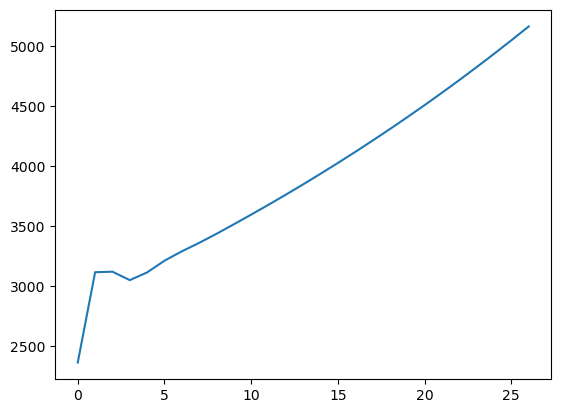

In [169]:
# use the gdp forecast to predict the mdv sales numbers 

last_mdv_num = mdv_data[mdv_data['year']==2023]['value']
last_mdv_num = int(last_mdv_num.values[0])
mdv_vehicles_forecast = []
mdv_sales_forecast = []
for val in gdp_forecast_data:
    mdv_vehicles_forecast.append(last_mdv_num+last_mdv_num*val*.01)
    mdv_sales_forecast.append(last_mdv_num*val*.01)
    last_mdv_num = mdv_vehicles_forecast[-1]
plt.plot(mdv_sales_forecast)


C:\Users\konar\AppData\Local\Temp\ipykernel_31940\875401049.py:12: RuntimeWarning: invalid value encountered in cast
  mdv_ev_data_arr = np.array(mdv_ev_data['value']).astype(int)


,Unnamed: 0,year,province,vehicle_type,fuel_type,value
413,413,2017,Alberta,"Total, vehicles weighing 11,794 kilograms or more",Battery electric,NaN
414,414,2018,Alberta,"Total, vehicles weighing 11,794 kilograms or more",Battery electric,NaN
415,415,2019,Alberta,"Total, vehicles weighing 11,794 kilograms or more",Battery electric,NaN
416,416,2020,Alberta,"Total, vehicles weighing 11,794 kilograms or more",Battery electric,NaN
417,417,2021,Alberta,"Total, vehicles weighing 11,794 kilograms or more",Battery electric,NaN
418,418,2022,Alberta,"Total, vehicles weighing 11,794 kilograms or more",Battery electric,NaN
419,419,2023,Alberta,"Total, vehicles weighing 11,794 kilograms or more",Battery electric,NaN


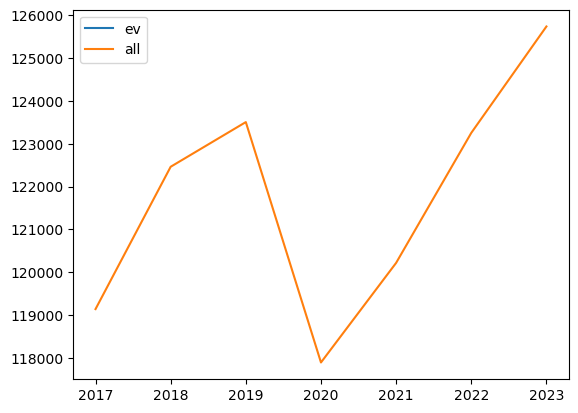

In [174]:

#get the past EV market share

mdv_ev_data = vehicle_registration_data[(vehicle_registration_data['vehicle_type']==mdv) \
                                              & (vehicle_registration_data['fuel_type']=='Battery electric') \
                                                   & (vehicle_registration_data['province']==province)]

plt.plot(mdv_ev_data['year'], mdv_ev_data['value'], label='ev')
plt.plot(mdv_ev_data['year'], mdv_data['value'], label='all')
plt.legend()

#get past sales percent
mdv_ev_data_arr = np.array(mdv_ev_data['value']).astype(int)
sales_data_mdv_ev = mdv_ev_data_arr[1:] - mdv_ev_data_arr[0:-1]

mdv_data_arr = np.array(mdv_data['value']).astype(int)
sales_data_mdv = mdv_data_arr[1:] - mdv_data_arr[0:-1]

sales_percent = np.divide(sales_data_mdv_ev, sales_data_mdv)*100
sales_year = [i for i in range(2018, 2024)]

#add the govt sales target
sales_percent = np.concatenate((sales_percent, np.array([30, 60, 100])))
sales_year = np.concatenate((sales_year, np.array([2030, 2040, 2050])))


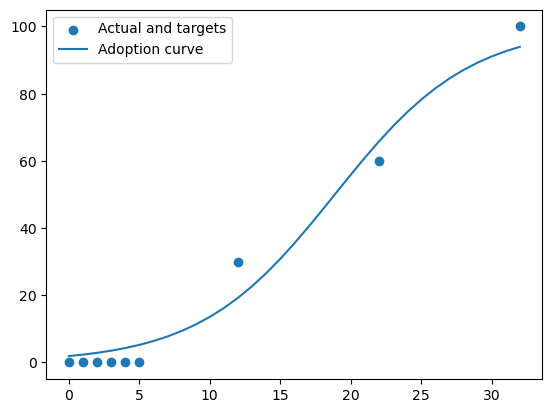

In [15]:
# predict sales values across years using curve fitting

from scipy.optimize import curve_fit#adoption curve for EV 

def func(x, mew, s):
    y = 100/(1+np.exp(-(mew+x*s)))
    return (y)

# fit curve
param, param_conv = curve_fit(func, sales_year-2018, sales_percent, method='dogbox')
years = np.linspace(2018, 2050, 33) - 2018
ev_percent_sales_forecast = func(years, *param)

plt.scatter(sales_year-2018, sales_percent, label='Actual and targets')
plt.plot(years, func(years, *param), label='Adoption curve')
plt.legend()

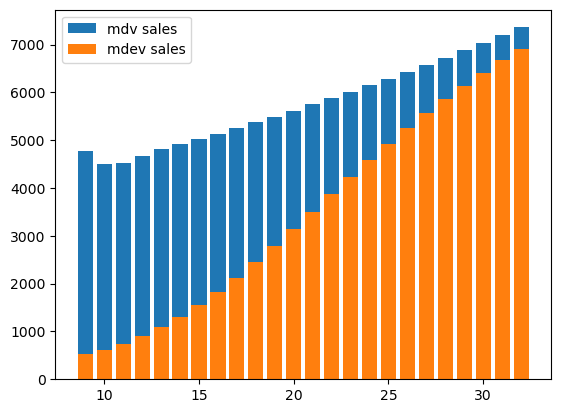

In [18]:
# forecasting the number of MDEVs on road till 2050 

mdv_ev_sales_forecast = mdv_sales_forecast * ev_percent_sales_forecast[9:]/100

plt.bar(years[9:], mdv_sales_forecast, label='mdv sales')
plt.bar(years[9:], mdv_ev_sales_forecast, label='mdev sales')
plt.legend()

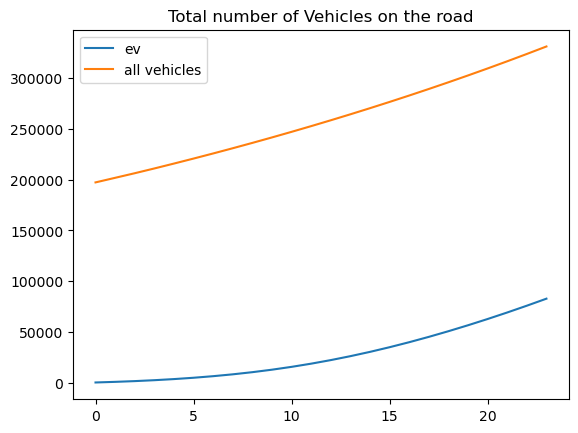

In [34]:
# use sales forecast numbers to calculate the total number of M/HDEVs on the road

mdv_ev_vehicle_numbers = np.array([mdv_ev_data_arr[-1]+np.sum(mdv_ev_sales_forecast[0:i+1]) for i in range(len(mdv_ev_sales_forecast))])
mdv_vehicle_numbers = np.array([mdv_data['value'].iloc[-1]+np.sum(mdv_sales_forecast[0:i+1]) for i in range(len(mdv_ev_sales_forecast))])
plt.plot(mdv_ev_vehicle_numbers, label='ev')
plt.plot(mdv_vehicle_numbers, label='all vehicles')
plt.title("Total number of Vehicles on the road")
plt.legend()

Text(0, 0.5, 'gigawatts')

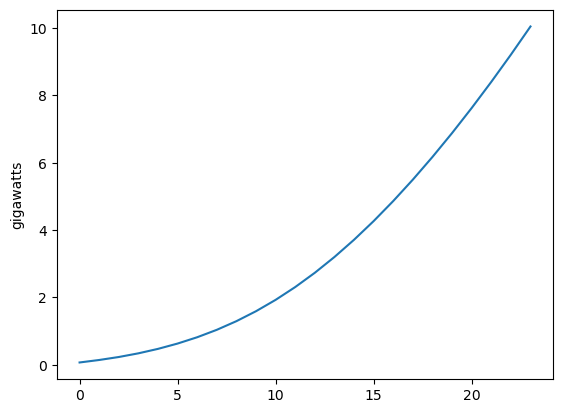

In [47]:
# find yearly mileage of one EV
# obtained from https://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/menus/trends/comprehensive_tables/list.cfm
mdv_mileage_province = {'Alberta' : 24230,
                        'British Columbia': 25255, 
                        'Manitoba': 13057,
                        'New Brunswick': 17439, 
                        'Newfoundland and Labrador': 21227, 
                        'Northwest Territories': 0, 
                        'Nova Scotia': 18587,
                        'Nunavut': 0, 
                        'Ontario': 19193, 
                        'Prince Edward Island': 15401, 
                        'Quebec': 22200, 
                        'Saskatchwan': 24657,
                        'Yukon': 0,
                       }

hdv_mileage_province = {'Alberta' : 67117,
                        'British Columbia': 52543, 
                        'Manitoba': 48950,
                        'New Brunswick': 40164, 
                        'Newfoundland and Labrador': 105288, 
                        'Northwest Territories': 0, 
                        'Nova Scotia': 72855,
                        'Nunavut': 0, 
                        'Ontario': 93230, 
                        'Prince Edward Island': 19901, 
                         'Quebec': 94188, 
                         'Saskatchwan': 62381, 
                        'Yukon': 0
                        
                       }

province = 'Alberta'
# kWatts/km for MDEV
mdev_kw_per_km = 1.5
# kWatt/km for HDEV
hdev_kw_per_km = 2.7

#total power consumption 
total_power_requirement = mdv_ev_vehicle_numbers*mdv_mileage_province[province]*mdev_kw_per_km/1000000

plt.plot(total_power_requirement)
plt.ylabel('gigawatts')


# Putting it all together

In [77]:
#load data
import re 
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

gdp_filename = '../data/formatted_data/gdp_data.xls'
gdp_data = pd.read_excel(gdp_filename)

vehicle_registration_data = pd.read_csv('../data/formatted_data/provincewise_vehicle_registration_data_formatted.csv').fillna(0)
mdv = "Total, vehicles weighing 4,536 to 11,793 kilograms" 
hdv = "Total, vehicles weighing 11,794 kilograms or more"

mdv = hdv
# find yearly mileage of one EV
# obtained from https://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/menus/trends/comprehensive_tables/list.cfm
mdv_mileage_province = {'Alberta' : 24230,
                        'British Columbia': 25255, 
                        'Manitoba': 13057,
                        'New Brunswick': 17439, 
                        'Newfoundland and Labrador': 21227, 
                        'Northwest Territories': 22235, 
                        'Nova Scotia': 18587,
                        'Nunavut': 22235, 
                        'Ontario': 19193, 
                        'Prince Edward Island': 15401, 
                        'Quebec': 22200, 
                        'Saskatchewan': 24657,
                        'Yukon': 22235,
                       }

hdv_mileage_province = {'Alberta' : 67117,
                        'British Columbia': 52543, 
                        'Manitoba': 48950,
                        'New Brunswick': 40164, 
                        'Newfoundland and Labrador': 105288, 
                        'Northwest Territories': 74654, 
                        'Nova Scotia': 72855,
                        'Nunavut': 74654, 
                        'Ontario': 93230, 
                        'Prince Edward Island': 19901, 
                        'Quebec': 94188, 
                        'Saskatchewan': 62381, 
                        'Yukon': 74654
                        
                       }

# kWatts/km for MDEV
ev_intensity = pd.read_csv('../data/formatted_data/ev_intensity.csv')
mdev_kw_per_km = ev_intensity[ev_intensity['vehicle_class'].isin([2,3,4,5,6])]['intensity_kW/km'].mean()
#mdev_kw_per_km = 1.5
# kWatt/km for HDEV
hdev_kw_per_km = ev_intensity[ev_intensity['vehicle_class'].isin([7,8 ])]['intensity_kW/km'].mean()


cols = [i for i in range(1980, 2030)] #gdp data availability
gdp_arr = gdp_data[cols]
gdp_arr_long = pd.melt(gdp_arr, value_vars=cols, var_name='year')
gdp_arr_long.set_index('year')

# build model
start_year_gdp = 2024
end_year_gdp = 2050
cut_off_year = 2030-start_year_gdp
model = ARIMA(gdp_arr_long['value'][0:-cut_off_year], order=(2,0,1))
fitted_model = model.fit()

# Forecast future points
forecast_years = [i for i in range(start_year_gdp, end_year_gdp+1)]
forecast_steps = len(forecast_years)

gdp_forecast_data = fitted_model.get_forecast(steps=forecast_steps).predicted_mean





province_list = list(hdv_mileage_province.keys())

canadawide_forecast_data = pd.DataFrame(columns=['province', 
                                      'year', 
                                      'vehicle_type', 
                                      'fuel_type', 
                                      'sales_percent',
                                      'sales_numbers', 
                                      'market_share_numbers',
                                      'yearly_mileage (km)',
                                      'power_required (GWh)'])

    
for province in province_list:
    
    # use the gdp forecast to predict the mdv sales numbers 
    mdv_data = vehicle_registration_data[(vehicle_registration_data['vehicle_type']==mdv) \
                                                  & (vehicle_registration_data['fuel_type']=='All fuel types') \
                                                    & (vehicle_registration_data['province']==province)]

    last_mdv_num = mdv_data[mdv_data['year']==2023]['value']
    last_mdv_num = int(last_mdv_num.values[0])

    mdv_vehicles_forecast = []
    mdv_sales_forecast = []
    for val in gdp_forecast_data:
        mdv_vehicles_forecast.append(last_mdv_num+last_mdv_num*val*.01)
        mdv_sales_forecast.append(last_mdv_num*val*.01)
        last_mdv_num = mdv_vehicles_forecast[-1]
    #get the past EV market share


    mdv_ev_data = vehicle_registration_data[(vehicle_registration_data['vehicle_type']==mdv) \
                                                  & (vehicle_registration_data['fuel_type']=='Battery electric') \
                                                       & (vehicle_registration_data['province']==province)]

    #get past sales percent
    mdv_ev_data_arr = np.array(mdv_ev_data['value']).astype(int)
    sales_data_mdv_ev = mdv_ev_data_arr[1:] - mdv_ev_data_arr[0:-1]

    mdv_data_arr = np.array(mdv_data['value']).astype(int)
    sales_data_mdv = mdv_data_arr[1:] - mdv_data_arr[0:-1]
    sales_percent = np.divide(sales_data_mdv_ev, 
                              sales_data_mdv,  
                              out=np.zeros(len(sales_data_mdv)), 
                              where=sales_data_mdv>0)*100
    sales_year = [i for i in range(2018, 2024)]

    #add the govt sales target
    # 30% by 2030, 60% by 2040 and 100% by 2050 
    # https://www.canada.ca/en/services/environment/weather/climatechange/climate-plan/climate-plan-overview/emissions-reduction-2030/sector-overview.html#sector6
    sales_percent = np.concatenate((sales_percent, np.array([30, 60, 100])))
    sales_year = np.concatenate((sales_year, np.array([2030, 2040, 2050])))

    # predict sales values across years using curve fitting


    def func(x, mew, s):
        y = 100/(1+np.exp(-(mew+x*s)))
        return (y)

    # fit curve
    param, param_conv = curve_fit(func, sales_year-2018, sales_percent, method='dogbox')
    years = np.linspace(2018, 2050, 33) - 2018
    ev_percent_sales_forecast = func(years, *param)


    # forecasting the number of MDEVs on road till 2050 

    mdv_ev_sales_forecast = mdv_sales_forecast * ev_percent_sales_forecast[6:]/100

    # use sales forecast numbers to calculate the total number of M/HDEVs on the road

    mdv_ev_vehicle_numbers = np.array([mdv_ev_data_arr[-1]+np.sum(mdv_ev_sales_forecast[0:i+1]) for i in range(len(mdv_ev_sales_forecast))])
    mdv_vehicle_numbers = np.array([mdv_data['value'].iloc[-1]+np.sum(mdv_sales_forecast[0:i+1]) for i in range(len(mdv_ev_sales_forecast))])

    #total power consumption 
    total_power_requirement = mdv_ev_vehicle_numbers*hdv_mileage_province[province]*hdev_kw_per_km/1000000
    
    #populate dataframe 
    # province: province
    # years : forecast_years
    # sales_percent: ev_percent_sales_forecast[6:]
    # sales_numbers: mdv_ev_sales_forecast / mdv_sales_forecast
    # market_share_numbers: mdv_ev_vehicle_numbers/ mdv_vehicle_numbers
    # power_required_gigawatts: total_power_requirement
    
    province_df_mdv = pd.DataFrame(
                                {'year': forecast_years, 
                                'province': province, 
                                'vehicle_type': mdv,
                                'fuel_type': 'All fuel type',
                                'sales_percent': 'na', 
                                'sales_numbers': mdv_sales_forecast, 
                                'market_share_numbers': mdv_vehicle_numbers, 
                                'yearly_mileage (km)': hdv_mileage_province[province],
                                'power_required (GWh)': [0]*len(forecast_years)}
                            )
    
    province_df_mdv_ev = pd.DataFrame(
                            {'year': forecast_years, 
                            'province': province, 
                            'vehicle_type': mdv,
                            'fuel_type': 'Battery electric',
                            'sales_percent': ev_percent_sales_forecast[6:], 
                            'sales_numbers': mdv_ev_sales_forecast, 
                            'market_share_numbers': mdv_ev_vehicle_numbers, 
                            'yearly_mileage (km)': hdv_mileage_province[province],
                            'power_required (GWh)': total_power_requirement}
                                     )
    
    province_forecast_data = pd.concat([province_df_mdv, province_df_mdv_ev])
    
    canadawide_forecast_data = pd.concat([canadawide_forecast_data, province_forecast_data])

canadawide_forecast_data.to_csv("canadawide_energy_requirement_forecast_hdev.csv")

C:\Users\konar\AppData\Local\Temp\ipykernel_35416\3892762939.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axbar = sns.barplot(hdev_data[hdev_data['fuel_type']=='Battery electric'].groupby(by=['year']).sum(), x='year',y='market_share_numbers')


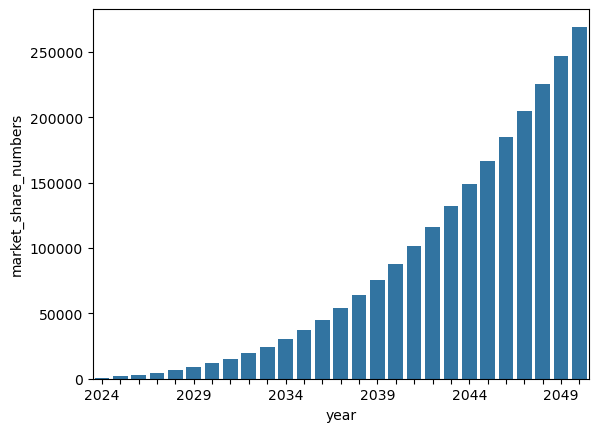

In [15]:
import seaborn as sns 
import pandas as pd 

mdev_data = pd.read_csv("../results/energy_forecast/canadawide_energy_requirement_forecast_mdev.csv")
hdev_data = pd.read_csv("../results/energy_forecast/canadawide_energy_requirement_forecast_hdev.csv")

total_data = pd.concat([mdev_data, hdev_data])
axbar = sns.barplot(hdev_data[hdev_data['fuel_type']=='Battery electric'].groupby(by=['year']).sum(), x='year',y='market_share_numbers')
#sns.move_legend(axbar, "upper left", bbox_to_anchor=(1, 1))
for ind, label in enumerate(axbar.get_xticklabels()):
    if ind % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)


In [8]:
axbar

<Axes: xlabel='year', ylabel='sales_numbers'>

C:\Users\konar\AppData\Local\Temp\ipykernel_32168\4018961213.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = sns.lineplot(canadawide_forecast_data[canadawide_forecast_data['fuel_type']=='Battery electric'].groupby('year').sum(), x='year',y='power_required (GWh)')


ValueError: Axes(0.125,0.11;0.775x0.77) has no legend attached.

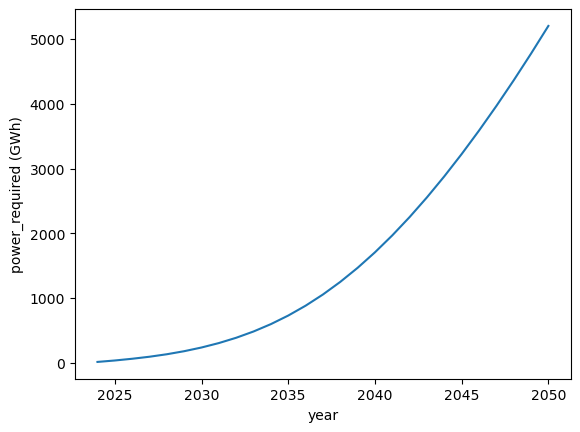

In [22]:
import seaborn as sns

#sns.lineplot(canadawide_forecast_data[canadawide_forecast_data['fuel_type']=='Battery electric'].groupby('year').sum(), x='year',y='sales_numbers')
ax = sns.lineplot(canadawide_forecast_data[canadawide_forecast_data['fuel_type']=='Battery electric'].groupby('year').sum(), x='year',y='power_required (GWh)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#canadawide_forecast_data[canadawide_forecast_data['fuel_type']=='Battery electric'].groupby('year').sum()


C:\Users\konar\AppData\Local\Temp\ipykernel_32168\2370427375.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axbar = sns.barplot(canadawide_forecast_data.groupby(by=['year','fuel_type']).sum(), hue='fuel_type', x='year',y='sales_numbers')


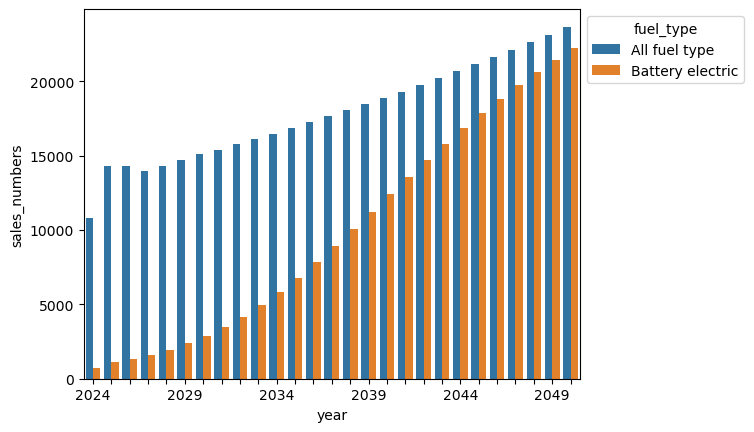

In [13]:
axbar = sns.barplot(canadawide_forecast_data.groupby(by=['year','fuel_type']).sum(), hue='fuel_type', x='year',y='sales_numbers')
sns.move_legend(axbar, "upper left", bbox_to_anchor=(1, 1))
for ind, label in enumerate(axbar.get_xticklabels()):
    if ind % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)



In [126]:
last_mdv_num 

Series([], Name: value, dtype: float64)

In [121]:
 sales_percent = np.divide(sales_data_mdv_ev, 
                              sales_data_mdv, out=np.zeros(len(sales_data_mdv)), where=sales_data_mdv>0)*100

In [122]:
sales_data_mdv_ev

array([0, 0, 0, 0, 0, 1])

In [123]:
sales_data_mdv

array([-368, -251,    0,  552,  227,   72])

In [278]:
canadawide_forecast_data[canadawide_forecast_data['fuel_type']=='Battery electric'].groupby('year').sum()

C:\Users\konar\AppData\Local\Temp\ipykernel_31940\211277220.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  canadawide_forecast_data[canadawide_forecast_data['fuel_type']=='Battery electric'].groupby('year').sum()


,sales_numbers,market_share_numbers,power_required_gigawatts
year,,,
2024,851.018356,935.018356,31.612859
2025,1357.230537,2292.248893,77.562114
2026,1639.586302,3931.835195,133.073102
2027,1926.374766,5858.209961,198.296728
2028,2354.022218,8212.232179,278.003232
2029,2890.834060,11103.066239,375.890198
2030,3505.293947,14608.360186,494.588362
2031,4210.949063,18819.309249,637.187402
2032,5025.455476,23844.764725,807.375101


In [189]:
vehicle_registration_data.iloc[6904]['value']

0.0

In [312]:
## read electric load current 

cur_data = pd.read_csv('../data/raw_data/load data/elec_load/elec_load/AB.csv')
#process data 

cur_data_lst = cur_data['LST']
cur_data['hour'] = cur_data['LST'].str.split(' ').str[1]
cur_data['year'] = cur_data_lst.str.split(' ').str[0].str.split('-').str[0]

cur_data['month'] = cur_data_lst.str.split(' ').str[0].str.split('-').str[1]
cur_data['day'] = cur_data_lst.str.split(' ').str[0].str.split('-').str[2]



cur_data_with_hp = pd.read_csv("../data/raw_data/load data/Total_incremental_hourly_electricity_usage/Total_incremental_hourly_electricity_usage/Total_incremental_hourly_electricity_usage/AB/total_incremental_hourly_electricity_load_AB_no_NG.csv")

In [311]:
cur_data['year'] = cur_data['LST'].str.split(' ').str[0].str.split('-').str[0]
cur_data['year']

0         2001
1         2001
2         2001
3         2001
4         2001
          ... 
131467    2015
131468    2015
131469    2015
131470    2015
131471    2016
Name: year, Length: 131472, dtype: object

<Axes: xlabel='LST', ylabel='load'>

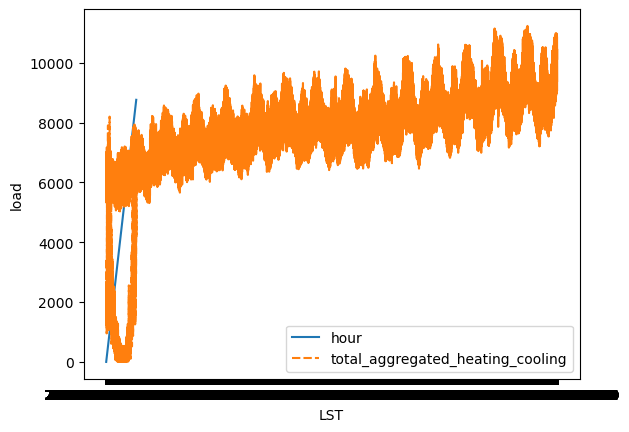

In [290]:
sns.lineplot(cur_data_with_hp,x='hour')
sns.lineplot(cur_data, x='LST', y='load')

In [344]:
ev_intensity = pd.read_csv('../data/formatted_data/ev_intensity.csv')
hdev_kw_per_km = ev_intensity[ev_intensity['vehicle_class'].isin([7,8 ])]['intensity_kW/km'].mean()
hdev_kw_per_km

1.2165711707142857

In [335]:
cur_data.groupby(['hour', 'day', 'month']).mean()

C:\Users\konar\AppData\Local\Temp\ipykernel_31940\3934417667.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cur_data.groupby(['hour', 'day', 'month']).mean()


load
hour day month             
0:00 01  01     8209.066667
         02     8052.333333
         03     7961.866667
         04     7396.466667
         05     6953.400000
...                     ...
9:00 31  05     7702.266667
         07     8146.333333
         08     7980.666667
         10     8357.600000
         12     8582.666667

[8784 rows x 1 columns]

# Load forecasting for MHDEV

## Formatting raw data

In [23]:


def convert_time_in_mins(data_list):
    time_in_mins= []
    for datapoint in data_list:
        data_list = datapoint.split(':')
        time_in_mins.append(int(data_list[0])*60+int(data_list[1]))
    return time_in_mins

combined_df['Charge Start Date'] = combined_df['Local Charge Start Time'].str.split(' ').str[0]
time_data_start = combined_df['Local Charge Start Time'].str.split(' ').str[1]
combined_df['Charge Start Time_mins'] = convert_time_in_mins(list(time_data_start))

combined_df['Charge End Date'] = combined_df['Local Charge End Time'].str.split(' ').str[0]
time_data_end = combined_df['Local Charge End Time'].str.split(' ').str[1]
combined_df['Charge End Time_mins'] = convert_time_in_mins(list(time_data_end))
combined_df['Charge Duration'] = time_diff
combined_df_opportunity = combined_df[combined_df['Charge Duration'] <=30]
combined_df.to_csv('mhdev_charging_behavior.csv')


NameError: name 'combined_df' is not defined

## Calculating charge percent for opportunity charging

In [256]:
## convert the mhdev_opportunity_charging_data to get an avg load curve
# assumption: charging rate : randomly between 350kW and 2MW (constant)

## Opportunity charging data 
mhdev_opportunity_charging_data_file = "D:/Work/eccc/data/formatted_data/mhdev_opportunity_charging_behavior.csv"
mhdev_opportunity_charging_data = pd.read_csv(mhdev_opportunity_charging_data_file)
mhdev_opportunity_charging_data_sub30 = mhdev_opportunity_charging_data.loc[(mhdev_opportunity_charging_data['Charge Duration'] <=30) & \
                                                                           (mhdev_opportunity_charging_data['Charge Duration'] > 3)]


daily_mean_charging_total = pd.DataFrame(columns=['vehicle_id', 'hours', 'charge_rate'])
vehicle_data = []

segments_per_day = 24
div_val = (60*24)/segments_per_day


hours = np.zeros(segments_per_day*(len(mhdev_opportunity_charging_data_sub30)))
charge_power = np.zeros(segments_per_day*(len(mhdev_opportunity_charging_data_sub30)))

for i in range(len(mhdev_opportunity_charging_data_sub30)):
    datapoint = mhdev_opportunity_charging_data_sub30.iloc[i]
    vehicle_id = datapoint['Vehicle ID']
    start_hour = int(datapoint["Charge Start Time_mins"]/div_val)
    end_hour = int(datapoint["Charge End Time_mins"]/div_val)
    charge_stats = np.zeros(segments_per_day)
    charge_stats[start_hour:end_hour+1] = 1
    charge_power_indiv = charge_stats

    vehicle_data.extend([vehicle_id]*segments_per_day)
    hours[i*segments_per_day:(i+1)*segments_per_day] = np.arange(segments_per_day)
    charge_power[i*segments_per_day: (i+1)*segments_per_day] = charge_power_indiv
    
daily_mean_charging_total['vehicle_id'] = vehicle_data 
daily_mean_charging_total['hours'] = hours 
daily_mean_charging_total['charge_rate'] = charge_power 


vehicle_charge_pattern = daily_mean_charging_total.groupby(['vehicle_id', 'hours'], as_index=False).sum()
vehicle_charge = daily_mean_charging_total.groupby(['vehicle_id'], as_index=False).sum()

total_charge_percent = []
for vehicle in vehicle_charge_pattern['vehicle_id'].unique():
    percent_charge = vehicle_charge_pattern[vehicle_charge_pattern['vehicle_id']==vehicle]['charge_rate']/vehicle_charge[vehicle_charge['vehicle_id']==vehicle]['charge_rate'].item()
    total_charge_percent.extend(percent_charge)
vehicle_charge_pattern['charge_rate'] = total_charge_percent

vehicle_charge_pattern.rename(columns={'charge_rate': 'charge_percent'}, inplace='True')
vehicle_charge_pattern.to_csv('opportunity_charge_percent_per_hr.csv')

## Generating load profiles

### Mean power output from Depot and Opportunity chargers

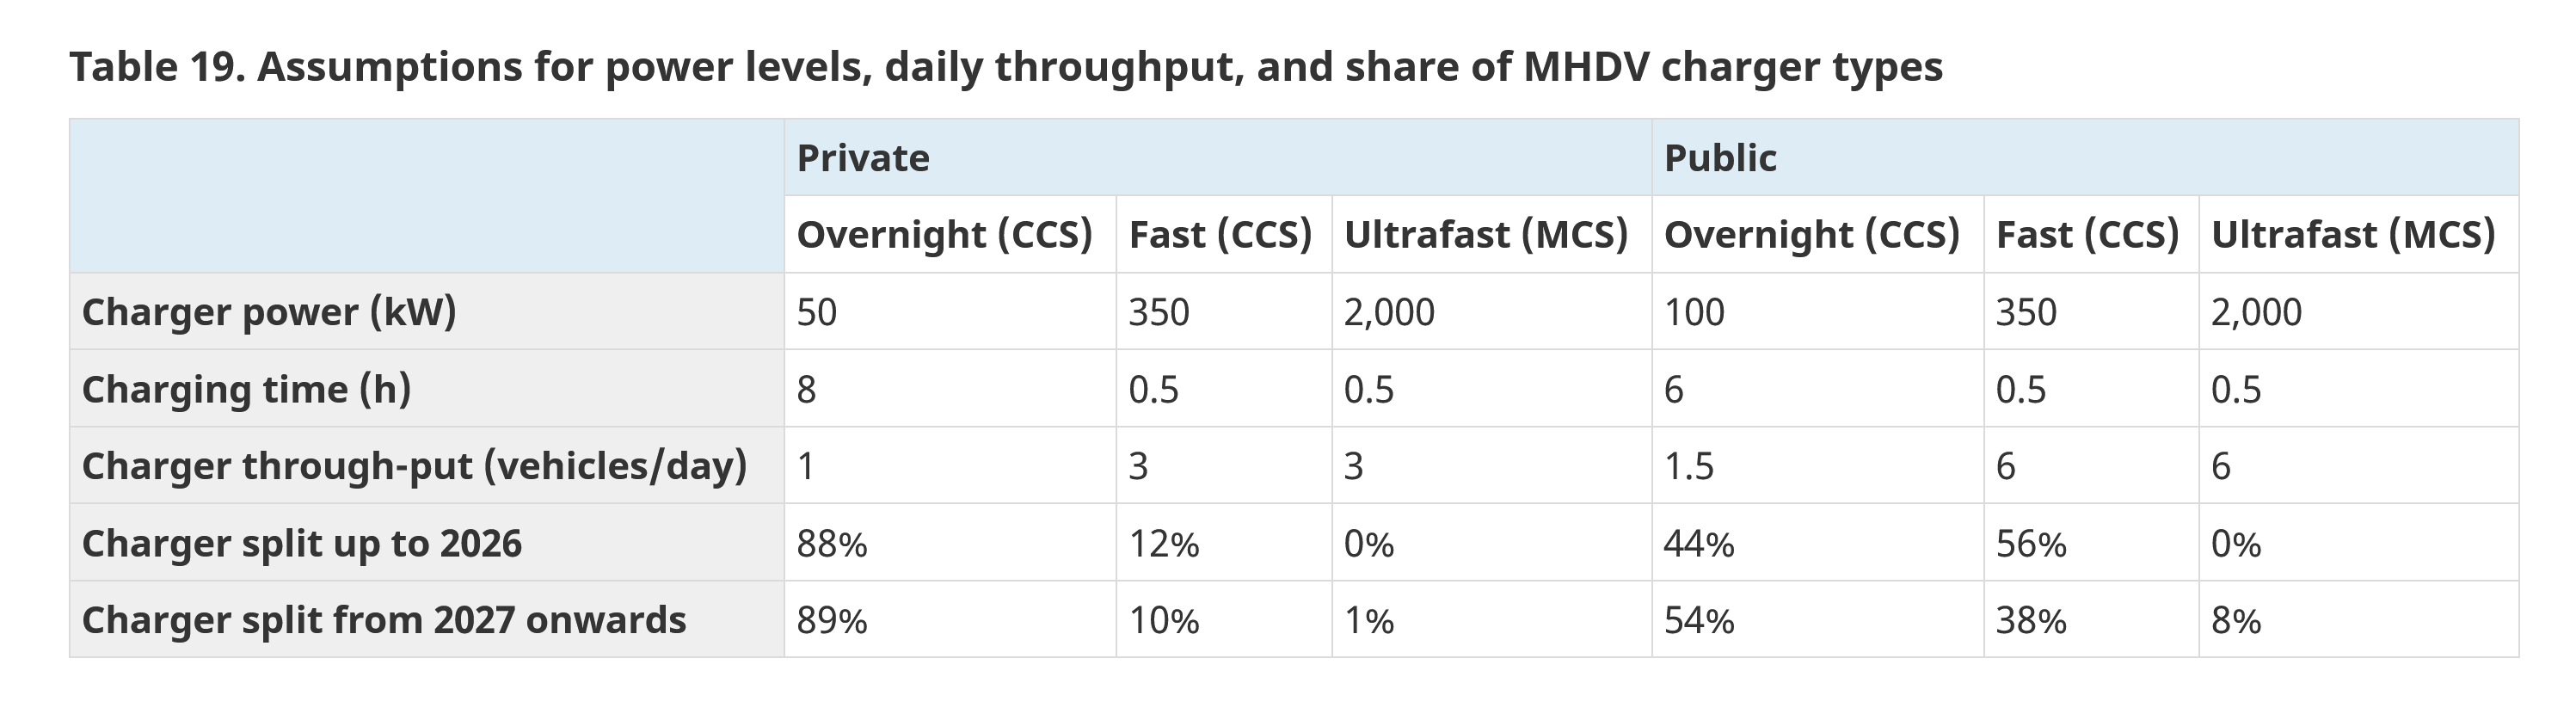

The above table from Dunsky is used as a reference.

For Opportunity Charging (Fast and Ultra Fast):
From 2024 - 2026 - 350kW
From 2027: 100%-0% in 2026 to 83%-17% in 2040 to 70%-30% in 2050 (Linear adoption rate)

In [255]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

charger_speed_opportunity = pd.DataFrame(columns=['year', '350mW', '2000mW', 'mean_power_output'])
years = np.arange(2024, 2051)
charge_percent_fast = np.ones(2051-2024)
charge_percent_ultrafast = np.zeros(2051-2024)

ratio = 17/14 #obtained from Dunsky 17% Ultrafast in 13 years 
charge_percent_ultrafast_calc = np.arange(25)*ratio/100
charge_percent_ultrafast[-25:] = charge_percent_ultrafast_calc
charger_speed_opportunity['year'] = years
charger_speed_opportunity['350mW'] = charge_percent_fast-charge_percent_ultrafast
charger_speed_opportunity['2000mW'] = charge_percent_ultrafast
charger_speed_opportunity['mean_power_output'] = charge_percent_fast*350 + charge_percent_ultrafast*2000


###  Calculating the load profile

MHDEVs are assumed to avail different types of charging to meet their needs. The distribution is used from the table below.

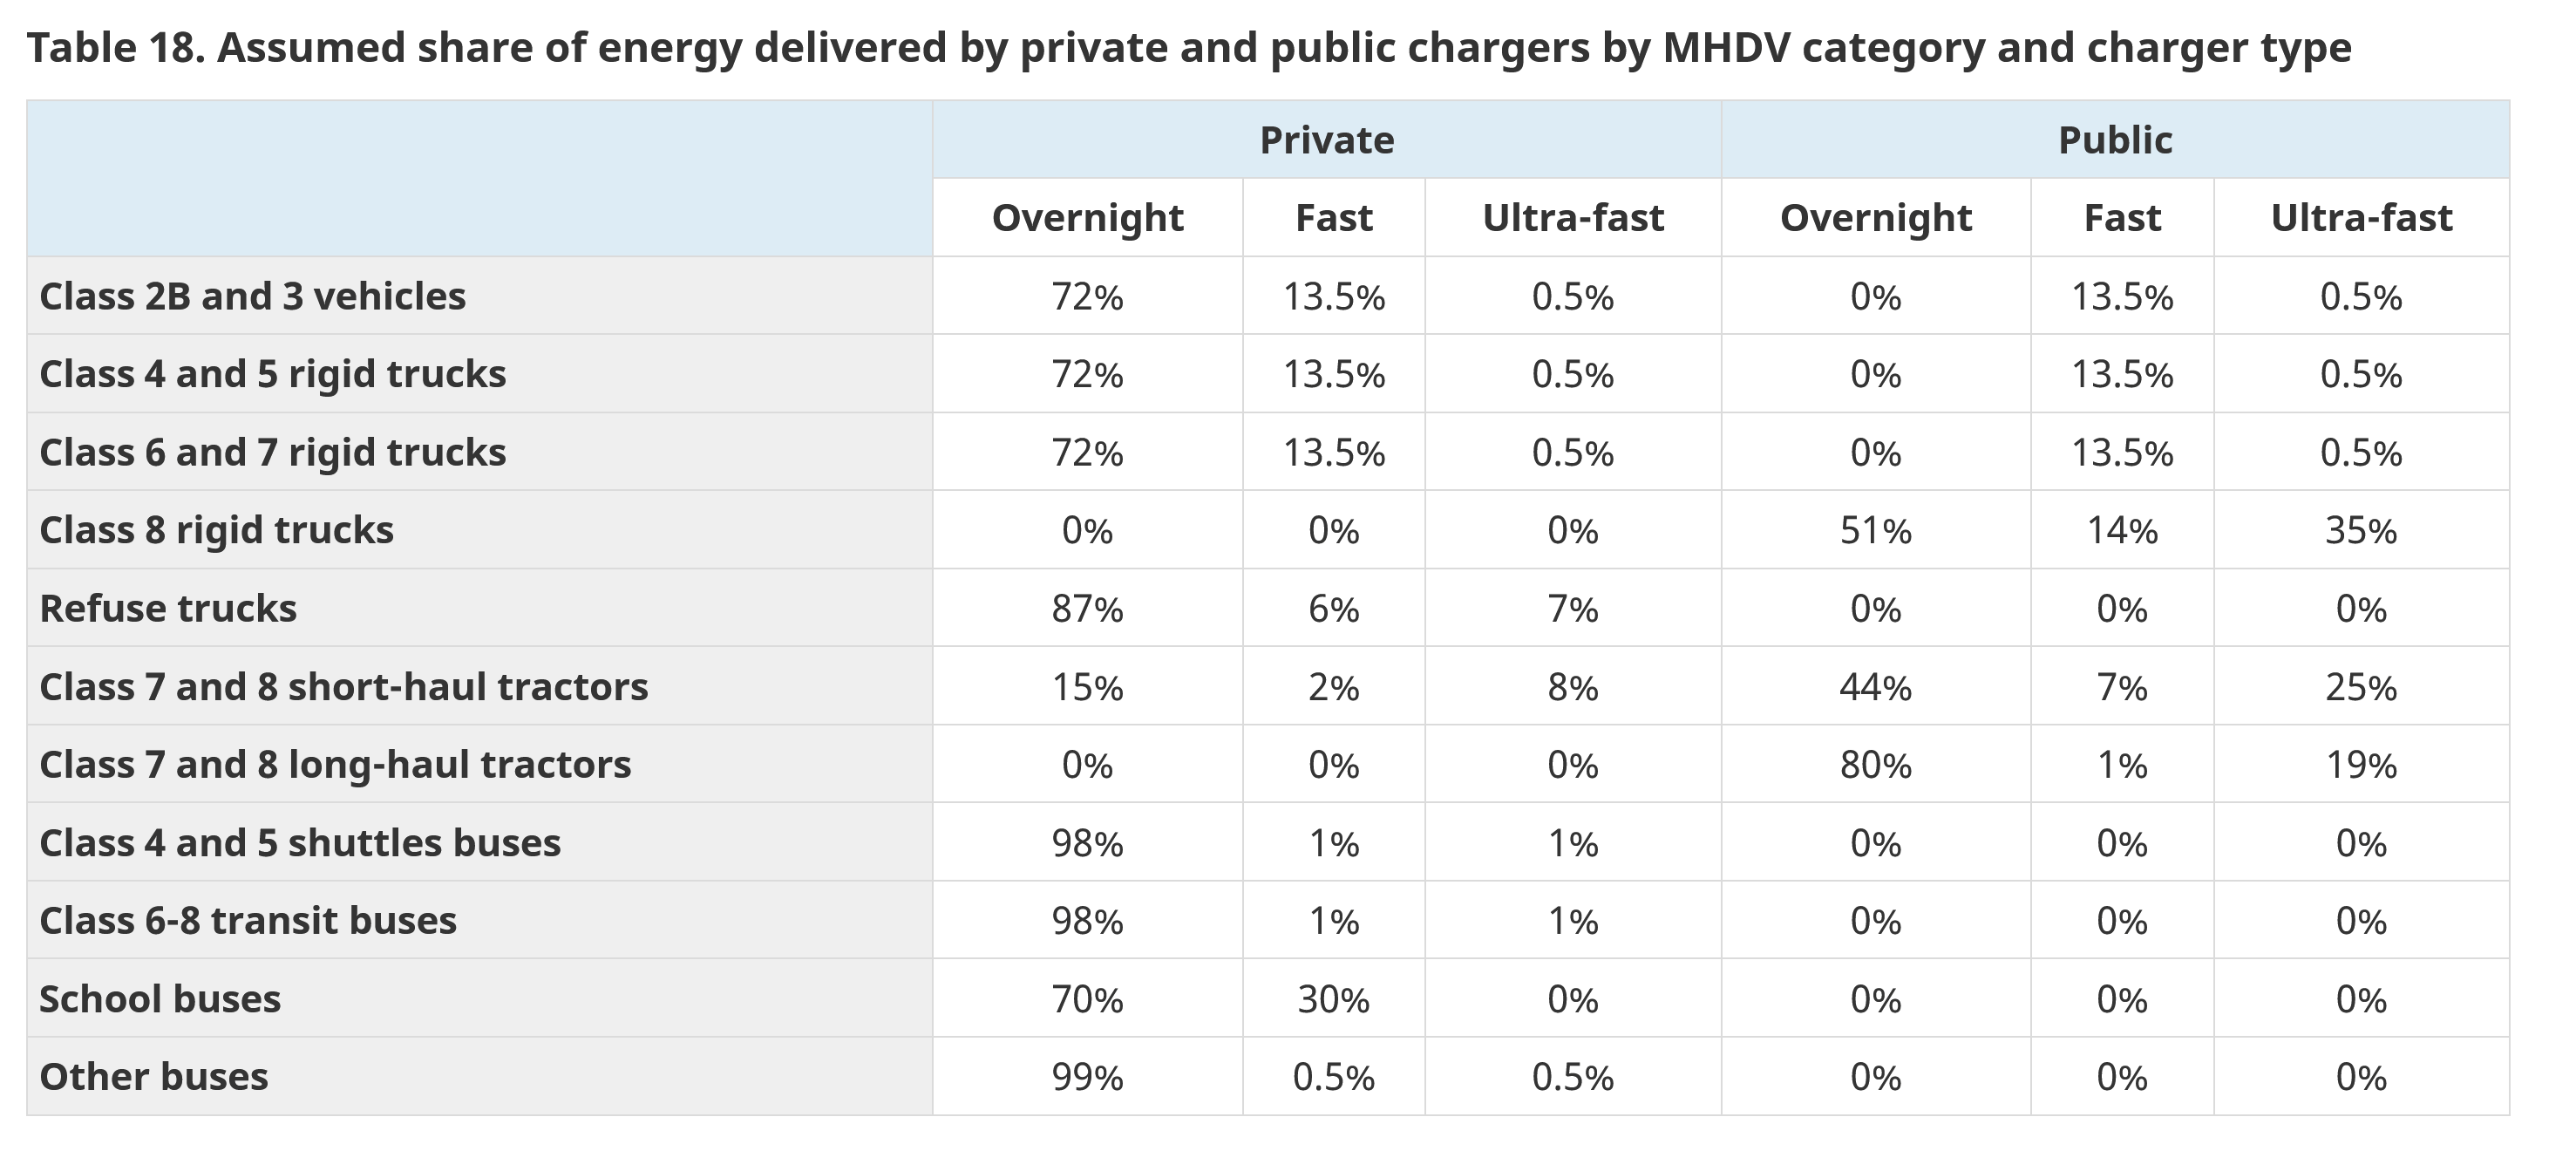


In [194]:
from scipy.signal import savgol_filter
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

vehicle_distribution_over_charger = {'mdev': {'depot_charge_percent': 0.72, 
                                              'opportunity_charge_percent': 0.28}, 
                                     'hdev': {'depot_charge_percent': 0.61, 
                                              'opportunity_charge_percent': 0.39}
                                    } # adding up fast and ultra fast charger


## Depot charging data
mhdev_depot_charging_data_file = "D:/Work/eccc/data/formatted_data/mhdev_depot_charge_percent_per_hr.xlsx"
mhdev_depot_charging_data = pd.read_excel(mhdev_depot_charging_data_file, sheet_name='Load_Curves')

load_percent_class = {
                        'mdev': ['2b_3', '4_5', '6_7'],
                        'hdev': ['6_7', '8']
                     }
## Depot charging data
mhdev_opportunity_charging_data_file = "D:/Work/eccc/data/formatted_data/mhdev_opportunity_charge_percent_per_hr.csv"
mhdev_opportunity_charging_data = pd.read_csv(mhdev_opportunity_charging_data_file)

charge_percent_data = {'depot_charge_percent' : mhdev_depot_charging_data, 
                       'opportunity_charge_percent': mhdev_opportunity_charging_data}

#vehicle numbers over the years
vehicle_types = ['mdev', 'hdev']

years = np.arange(2025, 2051)


# kWatts/km for MDEV
ev_intensity = pd.read_csv('../data/formatted_data/ev_intensity.csv')

#calculate 24hr load profiles across different years
#load profile largely remains the same for depot. For opportunity charging gets faster with years.

ev_forecast_data = pd.read_csv(f"../results/energy_forecast/canadawide_energy_requirement_forecast_mdev.csv")

provinces = ev_forecast_data['province'].unique()

#data for the final dataframe
vehicle_type_data = []
province_name_data = []
year_data = []
hour_data = []
load_type = []
load_value = []


for vehicle_type in vehicle_types:
    ev_forecast_data = pd.read_csv(f"../results/energy_forecast/canadawide_energy_requirement_forecast_{vehicle_type}.csv")
    
    if vehicle_type=='mhdev':
        ev_kw_per_km = ev_intensity[ev_intensity['vehicle_class'].isin([2,3,4,5,6])]['intensity_kW/km'].mean()
    else:
        ev_kw_per_km = ev_intensity[ev_intensity['vehicle_class'].isin([7,8 ])]['intensity_kW/km'].mean()

    for province in provinces:
        for year in years: 
            for charger_type in vehicle_distribution_over_charger[vehicle_type]:
                
                vehicle_numbers = ev_forecast_data[(ev_forecast_data['province']==province) & \
                                                   (ev_forecast_data['year']==year) & \
                                                   (ev_forecast_data['fuel_type']=='Battery electric')]['market_share_numbers']
                vehicles_using_cur_charging = vehicle_numbers*vehicle_distribution_over_charger[vehicle_type][charger_type]
                daily_mileage_avg = (sum(list(ev_forecast_data['yearly_mileage (km)'])) / \
                            len(list(ev_forecast_data['yearly_mileage (km)'])))/300

                total_daily_energy_requirement = (vehicles_using_cur_charging*daily_mileage_avg*ev_kw_per_km).item()
                
                current_charger_type_data = charge_percent_data[charger_type]
                daily_charge_percent = current_charger_type_data[current_charger_type_data['class'].isin(load_percent_class[vehicle_type])]
                daily_charge_profile = np.array(daily_charge_percent.groupby('hour').mean(numeric_only=True)['charge_percent'])
                
                #smooth if opportunity charging
                if charger_type=='opportunity_charge_percent':
                    daily_charge_profile = savgol_filter(daily_charge_profile, 6, 3) # window size 5, polynomial order 2

                daily_24h_load_profile = daily_charge_profile * total_daily_energy_requirement
                
                vehicle_type_data.extend([vehicle_type]*24)
                province_name_data.extend([province]*24)
                year_data.extend([year]*24)
                hour_data.extend(list(np.arange(24)))
                
                load_type.extend([charger_type.split('_')[0]] * 24)
                load_value.extend(list(daily_24h_load_profile))


load_profile_dataframe = pd.DataFrame({
                                        'vehicle_type': vehicle_type_data, 
                                        'province': province_name_data, 
                                        'year': year_data, 
                                        'hour': hour_data, 
                                        'load_type': load_type, 
                                        'load (kw)': load_value
                                    })
                

In [195]:
load_profile_dataframe.to_csv('daily_load_profile_across_year_province_charge_type.csv')

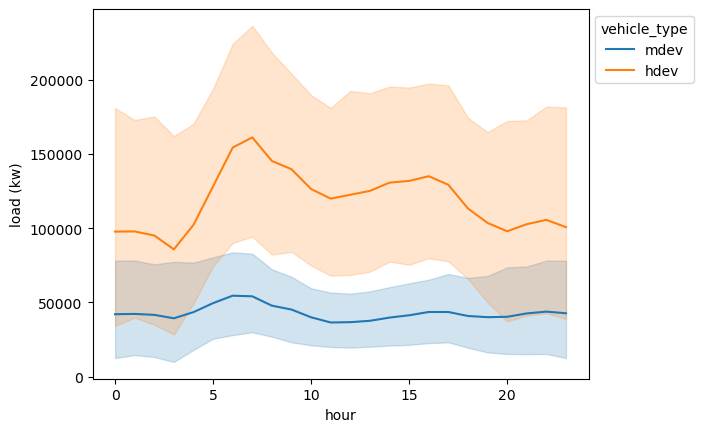

In [205]:
load_profile_dataframe_part = load_profile_dataframe[(load_profile_dataframe['year']==2050) & (load_profile_dataframe['load_type']=='opportunity')]

ax = sns.lineplot(load_profile_dataframe[(load_profile_dataframe['year']==2050)], x='hour', y='load (kw)', hue='vehicle_type')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [199]:
load_profile_dataframe

,vehicle_type,province,year,hour,load_type,load (kw)
0,mdev,Alberta,2025,0,depot,2086.043224
1,mdev,Alberta,2025,1,depot,2080.429793
2,mdev,Alberta,2025,2,depot,2063.651091
3,mdev,Alberta,2025,3,depot,2027.345116
4,mdev,Alberta,2025,4,depot,1969.484330
...,...,...,...,...,...,...
32443,hdev,Yukon,2050,19,opportunity,1249.702106
32444,hdev,Yukon,2050,20,opportunity,353.454628
32445,hdev,Yukon,2050,21,opportunity,344.053828
32446,hdev,Yukon,2050,22,opportunity,412.024124


## Calculating opportunity charging percentage updated

In [206]:
## convert the mhdev_opportunity_charging_data to get an avg load curve
# assumption: charging rate : randomly between 350kW and 2MW (constant)

## Opportunity charging data 
mhdev_opportunity_charging_data_file = "D:/Work/eccc/data/formatted_data/mhdev_opportunity_charging_behavior.csv"
mhdev_opportunity_charging_data = pd.read_csv(mhdev_opportunity_charging_data_file)
mhdev_opportunity_charging_data_relevant = mhdev_opportunity_charging_data.loc[(mhdev_opportunity_charging_data['Charge Duration'] <=30) & \
                                                                           (mhdev_opportunity_charging_data['Charge Duration'] > 0) & \
                                                                           (mhdev_opportunity_charging_data['Average Power'] > 100)]


daily_mean_charging_total = pd.DataFrame(columns=['vehicle_id', 'date' ,'hours', 'charge_rate'])

segments_per_day = 24
div_val = (60*24)/segments_per_day

# #get avg power and total charge time per day for each vehicle
# avg_power_across_charges_per_day = mhdev_opportunity_charging_data_relvant.groupby(['Vehicle ID', 'Charge Start Date'], as_index=False).mean()
# total_charge_time_across_charges_per_day = mhdev_opportunity_charging_data_relvant.groupby(['Vehicle ID', 'Charge Start Date'], as_index=False).sum()

vehicle_data = []
hours = []
charge_power = []
datelist = []


vehicle_ids = mhdev_opportunity_charging_data_relevant['Vehicle ID'].unique()
dates = mhdev_opportunity_charging_data_relevant['Charge Start Date'].unique()


for vehicle in vehicle_ids:
    for date in dates:
        
        particular_day_vehicle_info = mhdev_opportunity_charging_data_relevant[ \
                                             (mhdev_opportunity_charging_data_relevant['Vehicle ID']==vehicle) & \
                                                (mhdev_opportunity_charging_data_relevant['Charge Start Date']==date) 
                                                                          ]

        if len(particular_day_vehicle_info) > 0:
            
            vehicle_data_one_entry = [vehicle]*segments_per_day
            hours_one_entry = np.arange(segments_per_day)
            charge_power_one_entry = np.zeros(segments_per_day)
            date_one_entry = [date]*segments_per_day
            avg_powers = np.array(particular_day_vehicle_info['Average Power'])
            time_durations = np.array(particular_day_vehicle_info['Charge Duration'])
            total_power_drawn = sum(avg_powers*time_durations)
            
            for index, row in particular_day_vehicle_info.iterrows():
                row_start_time = int(row['Charge Start Time_mins']/div_val)
                charge_percent = (row['Charge Duration']*row['Average Power']) / total_power_drawn
                charge_power_one_entry[row_start_time] += charge_percent.item()
            

            vehicle_data.extend(vehicle_data_one_entry)
            hours.extend(list(hours_one_entry))
            charge_power.extend(list(charge_power_one_entry))
            datelist.extend(date_one_entry)
            
daily_mean_charging_total['vehicle_id'] = vehicle_data 
daily_mean_charging_total['hours'] = hours 
daily_mean_charging_total['charge_rate'] = charge_power 
daily_mean_charging_total['date'] = datelist

vehicle_charge_pattern = daily_mean_charging_total.groupby(['vehicle_id', 'hours'], as_index=False).sum()
vehicle_charge = daily_mean_charging_total.groupby(['vehicle_id'], as_index=False).sum()

total_charge_percent = []
for vehicle in vehicle_charge_pattern['vehicle_id'].unique():
    percent_charge = vehicle_charge_pattern[vehicle_charge_pattern['vehicle_id']==vehicle]['charge_rate']/vehicle_charge[vehicle_charge['vehicle_id']==vehicle]['charge_rate'].item()
    total_charge_percent.extend(percent_charge)
vehicle_charge_pattern['charge_rate'] = total_charge_percent

vehicle_charge_pattern.rename(columns={'charge_rate': 'charge_percent'}, inplace='True')
# vehicle_charge_pattern.to_csv('opportunity_charge_percent_per_hr.csv')


C:\Users\konar\AppData\Local\Temp\ipykernel_33820\1207858536.py:69: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vehicle_charge_pattern = daily_mean_charging_total.groupby(['vehicle_id', 'hours'], as_index=False).sum()
C:\Users\konar\AppData\Local\Temp\ipykernel_33820\1207858536.py:70: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vehicle_charge = daily_mean_charging_total.groupby(['vehicle_id'], as_index=False).sum()


In [150]:
particular_day_vehicle_info = mhdev_opportunity_charging_data_relevant[ \
                                             (mhdev_opportunity_charging_data_relevant['Vehicle ID']=='EV026') & \
                                                (mhdev_opportunity_charging_data_relevant['Charge Start Date']=='7/17/2018') 
                                                                          ]

<Axes: xlabel='hours', ylabel='charge_percent'>

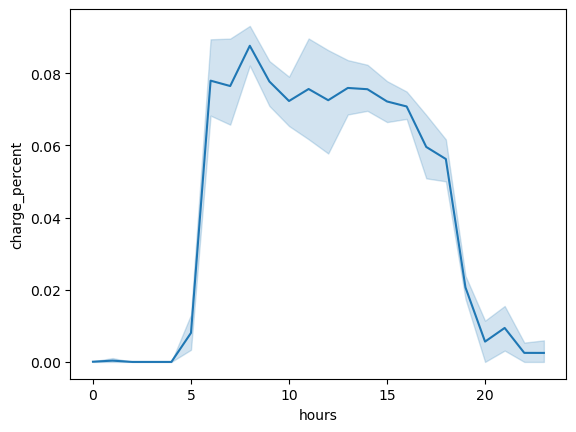

In [207]:
sns.lineplot(vehicle_charge_pattern, x='hours', y='charge_percent')

In [179]:
avg_power = np.array(particular_day_vehicle_info['Average Power'])
charge_duration = np.array(particular_day_vehicle_info['Charge Duration'])

sum(avg_power*charge_duration)

2865.053

In [190]:
daily_mean_charging_total.groupby(['vehicle_id', 'date']).sum()

hours  charge_rate
vehicle_id date                         
EV026      1/10/2018    276          1.0
           1/11/2018    276          1.0
           1/12/2018    276          1.0
           1/16/2018    276          1.0
           1/17/2018    276          1.0
...                     ...          ...
EV035      8/12/2018    276          1.0
           8/3/2018     276          1.0
           8/6/2018     276          1.0
           8/7/2018     276          1.0
           8/9/2018     276          1.0

[685 rows x 2 columns]

In [174]:
total_power_drawn

47    3263.22
dtype: float64

In [180]:
particular_day_vehicle_info



,Unnamed: 0,Vehice ID,Charger ID,Local Connect Time,Local Disconnect Time,Local Charge Start Time,Local Charge End Time,Average Power,Max Power,Total Energy Delivered,...,SOC Charged,Date,Number of Charging Sessions,Connection Time,Charging Time,Charge Start Date,Charge Start Time_mins,Charge End Date,Charge End Time_mins,Charge Duration
4494,267,NaN,CH007-CH008,NaN,NaN,6/4/2018 13:16,6/4/2018 13:29,181.351,351.18,NaN,...,NaN,NaN,NaN,NaN,NaN,6/4/2018,796,6/4/2018,809,13
4495,268,NaN,CH007-CH008,NaN,NaN,6/4/2018 9:42,6/4/2018 9:44,253.745,355.28,NaN,...,NaN,NaN,NaN,NaN,NaN,6/4/2018,582,6/4/2018,584,2


In [13]:
import pulp

def solve_grid_optimization_problem(
    existing_substations,  # Number of existing substations
    potential_new_locations,  # Number of potential new substation locations
    transformer_types,  # Number of transformer types
    conductor_types,  # Number of conductor types
    max_loads,  # Maximum expected load for each existing substation
    transformer_capacities,  # Capacity of each transformer type
    transformer_costs,  # Cost of each transformer type
    new_substation_cost,  # Cost of building a new substation
    conductor_costs  # Cost of each conductor type
):
    """
    Solve the grid optimization problem using PuLP
    """
    # Create the model
    model = pulp.LpProblem(name="grid_optimization", sense=pulp.LpMinimize)
    
    # Decision Variables
    # Transformer counts
    x = {}
    for i in range(len(existing_substations)):
        for k in range(len(transformer_types)):
            x[i,k] = pulp.LpVariable(
                name=f"transformer_count_{i}_{k}", 
                lowBound=0, 
                cat='Integer'
            )
    
    # New substation locations
    y = {}
    for j in range(potential_new_locations):
        y[j] = pulp.LpVariable(
            name=f"new_substation_{j}", 
            cat='Binary'
        )
    
    # Conductor counts
    z = {}
    for i in range(len(existing_substations)):
        for j in range(potential_new_locations):
            for l in range(len(conductor_types)):
                z[i,j,l] = pulp.LpVariable(
                    name=f"conductor_count_{i}_{j}_{l}", 
                    lowBound=0, 
                    cat='Integer'
                )
    
    # Objective Function
    model += (
        pulp.lpSum(x[i,k] * transformer_costs[k] 
            for i in range(len(existing_substations)) 
            for k in range(len(transformer_types))) +
        pulp.lpSum(y[j] * new_substation_cost 
            for j in range(potential_new_locations)) +
        pulp.lpSum(z[i,j,l] * conductor_costs[l] 
            for i in range(len(existing_substations)) 
            for j in range(potential_new_locations) 
            for l in range(len(conductor_types)))
    )
    
    # Load Capacity Constraint
    for i in range(len(existing_substations)):
        model += (
            pulp.lpSum(x[i,k] * transformer_capacities[k] 
                for k in range(len(transformer_types))) >= max_loads[i],
            f"Load_Capacity_Substation_{i}"
        )
    
    # New Substation Deployment Constraint
    M = 1000  # Big M constant
    for i in range(len(existing_substations)):
        for j in range(potential_new_locations):
            for l in range(len(conductor_types)):
                model += z[i,j,l] <= M * y[j], f"New_Substation_Constraint_{i}_{j}_{l}"
    
    # Limit on new substations
    model += (
        pulp.lpSum(y[j] for j in range(potential_new_locations)) <= 3,
        "Max_New_Substations"
    )
    
    # Minimum transformers per existing substation
    for i in range(len(existing_substations)):
        model += (
            pulp.lpSum(x[i,k] for k in range(len(transformer_types))) >= 1,
            f"Min_Transformers_Substation_{i}"
        )
    
    # Solve the model
    model.solve()
    
    # Check solution status
    print(f"Status: {pulp.LpStatus[model.status]}")
    
    # Print results if optimal solution found
    if pulp.LpStatus[model.status] == 'Optimal':
        print("\nOptimal Solution:")
        
        # Print transformer configuration
        print("\nTransformer Configuration:")
        for i in range(len(existing_substations)):
            for k in range(len(transformer_types)):
                if x[i,k].varValue > 0:
                    print(f"Substation {i}: {x[i,k].varValue} transformers of type {k}")
        
        # Print new substation locations
        print("\nNew Substation Locations:")
        for j in range(potential_new_locations):
            if y[j].varValue > 0:
                print(f"New substation at location {j}")
        
        # Print conductor deployments
        print("\nConductor Deployments:")
        for i in range(len(existing_substations)):
            for j in range(potential_new_locations):
                for l in range(len(conductor_types)):
                    if z[i,j,l].varValue > 0:
                        print(f"From Substation {i} to New Location {j}: {z[i,j,l].varValue} conductors of type {l}")
        
        print(f"\nTotal Cost: {pulp.value(model.objective)}")
    
    return model

# Example usage
def main():
    # Example parameters (you would replace these with your actual data)
    existing_substations = [0, 1, 2]  # 3 existing substations
    potential_new_locations = 4 # [0, 1, 2, 3]  # 4 potential new locations
    transformer_types = [0, 1, 2]  # 3 transformer types
    conductor_types = [0, 1]  # 2 conductor types
    
    # Maximum expected load for each existing substation
    max_loads = [50, 50, 200]
    
    # Transformer capacities for each type
    transformer_capacities = [50, 100, 200]
    
    # Costs for transformers
    transformer_costs = [10000, 15000, 25000]
    
    # Cost of building a new substation
    new_substation_cost = 53000
    
    # Conductor costs
    conductor_costs = [5000, 7000]
    
    # Solve the optimization problem
    solve_grid_optimization_problem(
        existing_substations,
        potential_new_locations,
        transformer_types,
        conductor_types,
        max_loads,
        transformer_capacities,
        transformer_costs,
        new_substation_cost,
        conductor_costs
    )

if __name__ == "__main__":
    main()


Status: Optimal

Optimal Solution:

Transformer Configuration:
Substation 0: 1.0 transformers of type 0
Substation 1: 1.0 transformers of type 0
Substation 2: 1.0 transformers of type 2

New Substation Locations:

Conductor Deployments:

Total Cost: 45000.0
